In [1]:
from tasks import get_single_label_mnist

tasks = get_single_label_mnist(10)

In [2]:
from pathlib import Path

from utils import seed_everything 

batch_size=64
seed=42

seed_everything(seed)

path = Path("/scratch/shared/beegfs/user/experiments/naive/vae/mnist/generative_naive/naive")
ckpts_dir = path / f"seed={seed}" / f"batch_size={batch_size}"

In [3]:
from torch.utils.data import DataLoader
from generative_models import VAE
from torch.distributions import Normal
from einops import repeat
import torch
import torch.nn.functional as F

@torch.inference_mode()
def compute_log_likelihood_importance(
  model: VAE,
  task_idx: int,
  test_dataloader: DataLoader,
  device: torch.device,
  num_importance_samples: int = 256,
):
  
  model.to(device)
  estimates = []
  for x, _ in test_dataloader:
    x = x.to(device)
    q_z_given_x = model.encoders[task_idx](x)
    p_z = Normal(
        torch.zeros_like(q_z_given_x.loc),
        torch.ones_like(q_z_given_x.scale)
    )
    z = q_z_given_x.rsample((num_importance_samples, ))    # [k, b, d]
    h = model.decoder_heads[task_idx](z)
    x_rec = model.decoder_tail(h)
    log_likelihood = -F.binary_cross_entropy(
        x_rec,
        repeat(x, "b d -> k b d", k=num_importance_samples),
        reduction="none"
    ).sum(dim=-1)
    log_prior = p_z.log_prob(z).sum(dim=-1)
    log_posterior = q_z_given_x.log_prob(z).sum(dim=-1)
    log_w = log_likelihood + (log_prior - log_posterior)
    estimate = torch.logsumexp(log_w, dim=0) - torch.log(torch.tensor(num_importance_samples))  # (B,)
    estimates.append(estimate)
    
  estimates = torch.cat(estimates, dim=0)

  return estimates.mean(), estimates.var()


In [4]:

from copy import deepcopy
from generative_models import VAE, NaiveDecoderTail
import torch

num_tasks = 10
hidden_dim = 500
input_dim = 28 * 28
latent_dim = 50
num_epochs = 200
lr = 0.0001
device = torch.device("cuda:2")

decoder_tail = NaiveDecoderTail(
  hidden_dim=hidden_dim,
  output_dim=input_dim
)

task_vaes = []

for (task_idx, _) in enumerate(tasks):
    model = VAE(
      num_tasks=num_tasks,
      input_dim=input_dim,
      latent_dim=latent_dim,
      hidden_dim=hidden_dim,
      decoder_tail=decoder_tail
    )

    model.load_state_dict(torch.load(ckpts_dir / f"after_{task_idx}.pth"))
    task_vaes.append(deepcopy(model))

/tmp/ipykernel_3234299/47356594.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpts_dir / f"after_{task_idx}.pth"))


In [5]:
import numpy as np

avg_ll_per_vae = [] 
for vae_idx in range(len(task_vaes)):

    task_lls = []
    for task_idx in range(vae_idx + 1):
        test_dataloader = DataLoader(
            dataset=tasks[task_idx].test,
            batch_size=batch_size
        )
        ll, _ = compute_log_likelihood_importance(
            task_vaes[vae_idx],
            task_idx,
            test_dataloader,
            device
        )
        task_lls.append(ll)

    avg_ll_per_vae.append(torch.tensor(task_lls).mean().item())

avg_ll_per_vae = np.array(avg_ll_per_vae)

In [6]:
average_df = {
    "method": ["VCL"],
    "average_ll": [avg_ll_per_vae]
}

/tmp/ipykernel_3234299/4175712322.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', len(average_df["method"]))


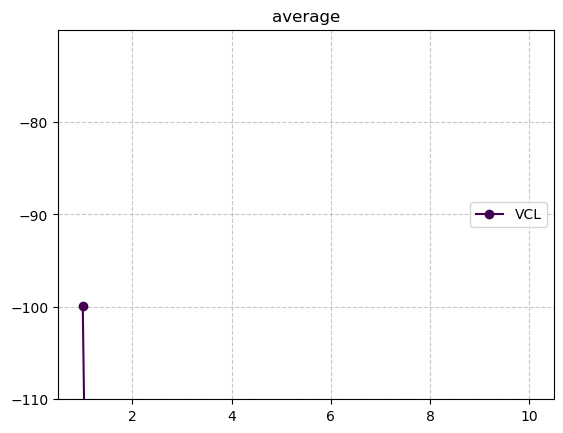

In [7]:

# Create a figure with subplots in a row
from matplotlib import cm, pyplot as plt
import numpy as np
viridis = cm.get_cmap('viridis', len(average_df["method"]))


x = np.arange(1, 11, 1)
for i, (method, ll) in enumerate(zip(average_df["method"], average_df["average_ll"])):
    plt.plot(
        x,
        ll,
        marker='s' if "Only" in method else 'o',
        linestyle='--' if "Only" in method else '-',
        color=viridis(i),
        label=method,
    )
    plt.ylim((-110, -70))
    plt.yticks(np.arange(-110, -70, 10))
    plt.xlim(0.5, 10.5)
    plt.title(f'average')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='center right')



In [8]:
ll_per_task = []
for task_idx in range(10):
    test_dataloader = DataLoader(
        dataset=tasks[task_idx].test,
        batch_size=batch_size
    )
    elbos = []
    for (t, task_vae) in enumerate(task_vaes[task_idx:]):
        ll, _ = compute_log_likelihood_importance(task_vae, task_idx, test_dataloader, device)
        elbos.append(ll.cpu().numpy())
    ll_per_task.append(elbos)
    print("---")

---
---
---
---
---
---
---
---
---
---


In [9]:
ll_per_task

[[array(-99.8517, dtype=float32),
  array(-954.56384, dtype=float32),
  array(-447.61603, dtype=float32),
  array(-471.0206, dtype=float32),
  array(-642.5457, dtype=float32),
  array(-538.4614, dtype=float32),
  array(-610.61, dtype=float32),
  array(-755.23474, dtype=float32),
  array(-624.525, dtype=float32),
  array(-842.4664, dtype=float32)],
 [array(-44.502083, dtype=float32),
  array(-131.0791, dtype=float32),
  array(-147.82129, dtype=float32),
  array(-200.15828, dtype=float32),
  array(-159.00594, dtype=float32),
  array(-219.34207, dtype=float32),
  array(-217.53975, dtype=float32),
  array(-174.37715, dtype=float32),
  array(-231.69171, dtype=float32)],
 [array(-101.386475, dtype=float32),
  array(-213.05376, dtype=float32),
  array(-283.6011, dtype=float32),
  array(-304.3937, dtype=float32),
  array(-300.51892, dtype=float32),
  array(-455.3389, dtype=float32),
  array(-292.64667, dtype=float32),
  array(-436.38593, dtype=float32)],
 [array(-97.135414, dtype=float32),
  a

In [10]:
df = {
    "method": ["VCL"],
    "ll": [ll_per_task],
}

/tmp/ipykernel_3234299/3315415237.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', len(df["method"]))


[('A', 'F'), ('B', 'G'), ('C', 'H'), ('D', 'I'), ('E', 'J')]


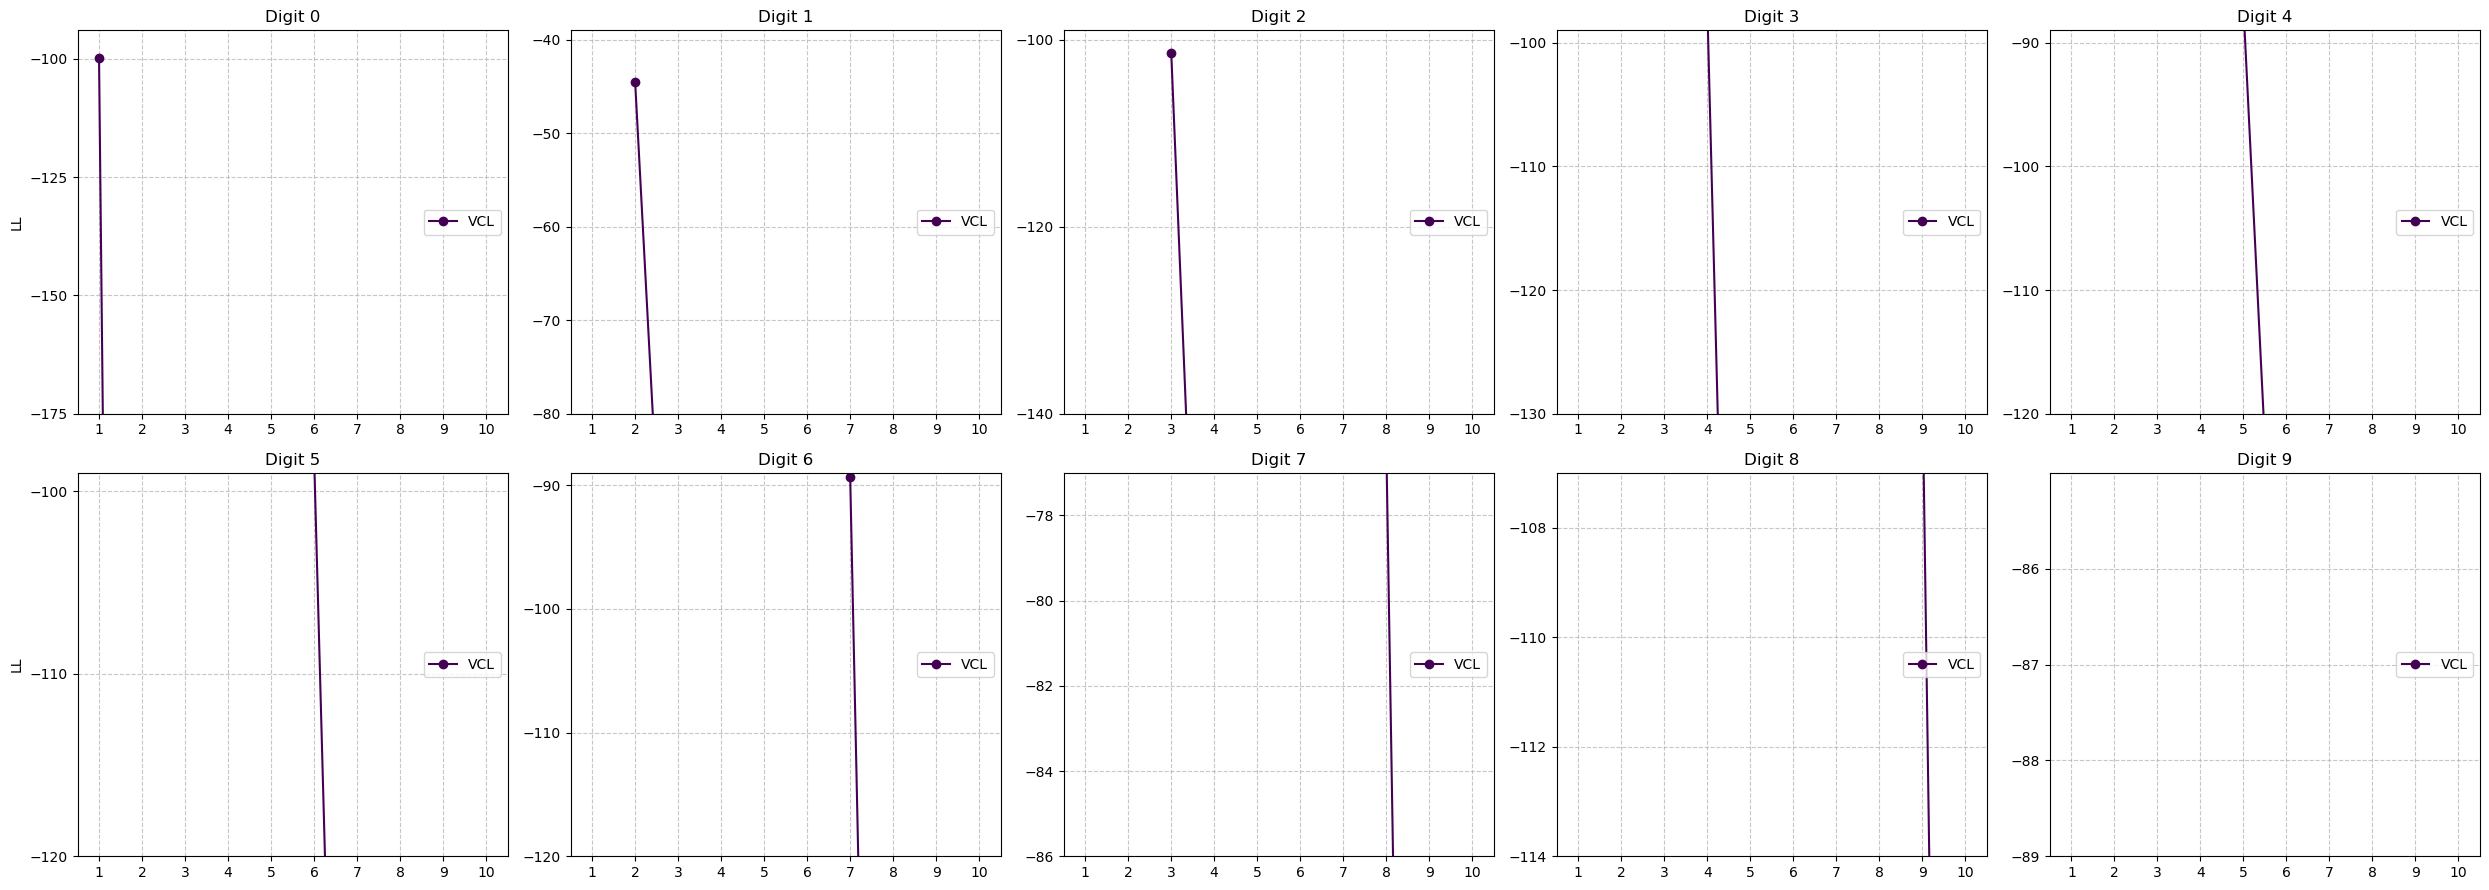

In [11]:
num_tasks = 10

# Create a figure with subplots in a row
from matplotlib import cm, pyplot as plt
import numpy as np



fig, axes = plt.subplots(2, 5, figsize=(25, 9))
axes = axes.flatten()  # Easier indexing

plot_ylims = [
    (-175, -95, 25),
    (-80, -40, 10),
    (-140, -100, 20),
    (-130, -100, 10),
    (-120, -90, 10),
    (-120, -100, 10),
    (-120, -90, 10),
    (-86, -78, 2),
    (-114, -108, 2),
    (-89, -86, 1),
]

viridis = cm.get_cmap('viridis', len(df["method"]))

task_titles = [("A", "F"), ("B", "G"), ("C", "H"), ("D", "I"), ("E", "J")]
print(task_titles)

for task in range(num_tasks):
    ax = axes[task]
    
    ax.set_xticks(np.arange(1, 11))
    x = np.arange(task + 1, 11)  # x goes from task+1 to 10
    
    for i, (method, ll) in enumerate(zip(df["method"], df["ll"])):
        if method != "K-Center Coreset Only":
            ax.plot(
                x,
                ll[task],
                marker='s' if "Only" in method else 'o',
                linestyle='--' if "Only" in method else '-',
                color=viridis(i),
                label=method,
            )
    
    y_min, y_max, y_ticks = plot_ylims[task]
    y_max += 1
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max, y_ticks))
    ax.set_xlim(0.5, 10.5)

    ax.set_title(f'Digit {task}')
    ax.grid(True, linestyle='--', alpha=0.7)

    if task % 5 == 0:
        ax.set_ylabel('LL')

    ax.legend(loc='center right')

plt.tight_layout()
plt.show()


---
done with task


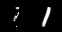

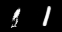

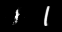

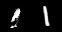

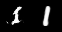

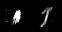

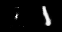

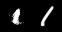

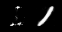

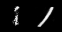

---
done with task


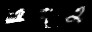

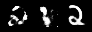

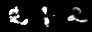

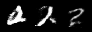

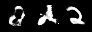

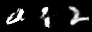

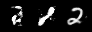

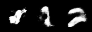

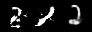

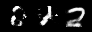

---
done with task


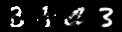

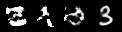

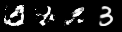

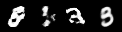

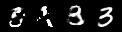

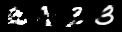

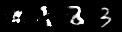

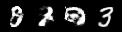

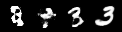

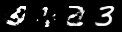

---
done with task


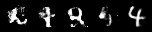

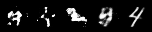

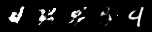

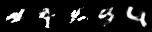

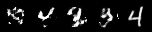

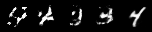

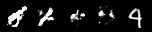

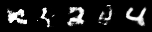

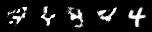

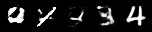

---
done with task


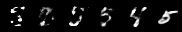

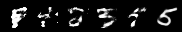

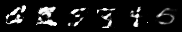

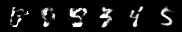

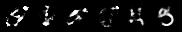

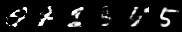

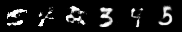

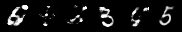

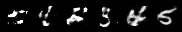

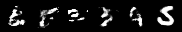

---
done with task


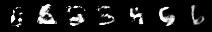

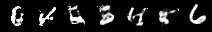

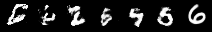

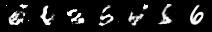

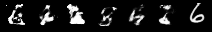

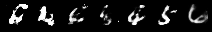

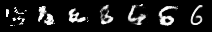

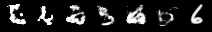

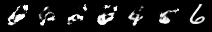

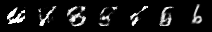

---
done with task


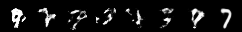

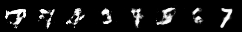

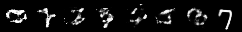

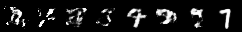

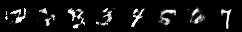

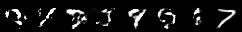

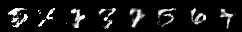

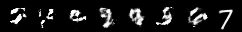

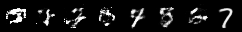

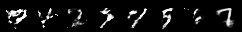

---
done with task


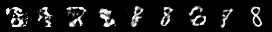

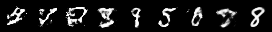

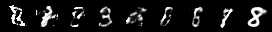

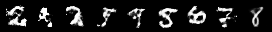

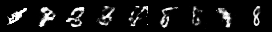

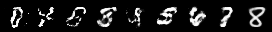

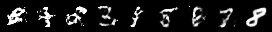

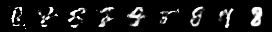

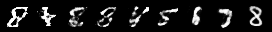

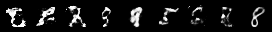

---
done with task


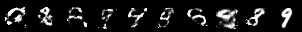

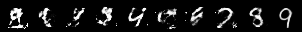

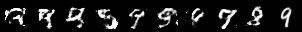

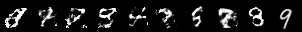

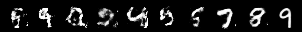

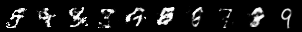

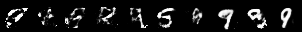

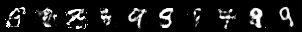

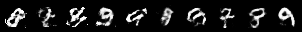

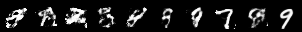

---
done with task


In [12]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

with torch.inference_mode():
    for (task_idx, model) in enumerate(task_vaes):
        for _ in range(10):
            samples = []
            for head_idx in range(0, task_idx + 1):
                samples.append(
                    model.sample(1, head_idx, device).view((1, 1, 28, 28))
                )

            samples = torch.cat(samples, dim=0)
            samples_row = to_pil_image(make_grid(samples, nrow=samples.shape[0]))
            samples_row.show()


        print("---")

        print("done with task")


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Literal
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import copy
import time

class Mlp(nn.Module):
    def __init__(self, in_features, out_features, activation: Literal["relu", "sigmoid", "identity"]):
        """
        Activation is a function (eg. torch.nn.functional.sigmoid/relu)
        """
        super().__init__()
        self.mean = nn.Linear(in_features, out_features)
        self.activation = activation
        self.reset_parameters(in_features, out_features)
    
    def _forward(self, x, weight, bias):
        x = F.linear(x, weight, bias)
        match self.activation:
            case "relu":
                return F.relu(x)
            case "sigmoid":
                return F.sigmoid(x)
            case _:
                return x
            
    def forward(self, x):
        weight = self.mean.weight
        bias = self.mean.bias
        return self._forward(x, weight, bias)

    def reset_parameters(self, in_features, out_features, constant=1.0):
        scale = constant * np.sqrt(6.0 / (in_features + out_features))
        nn.init.uniform_(self.mean.weight, -scale, scale)
        nn.init.zeros_(self.mean.bias)

class MNISTClassifier(nn.Module):
    def __init__(self, input_dim: int = 784, hidden_dim: int = 256):
        """
        MNIST Classifier model using MLP layers
        
        Args:
            input_dim: Input dimension (default: 784 for flattened MNIST images of 28x28 pixels)
            hidden_dim: Hidden layer dimension
        """
        super(MNISTClassifier, self).__init__()
        self.network = nn.Sequential(
            Mlp(input_dim, hidden_dim, "relu"),
            Mlp(hidden_dim, hidden_dim, "relu"),
            Mlp(hidden_dim, hidden_dim, "relu"),
            Mlp(hidden_dim, 10, "identity")  # 10 classes for MNIST
        )
    
    def forward(self, x):
        # Flatten the input if it's not already flattened
        if len(x.shape) > 2:
            batch_size = x.shape[0]
            x = x.view(batch_size, -1)
        
        logits = self.network(x)
        return logits
    
    def predict(self, x):
        """Return predicted class indices"""
        logits = self.forward(x)
        return torch.argmax(logits, dim=1)

def evaluate_model(model, data_loader, device):
    """Evaluate model accuracy on the provided data loader"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

def train_mnist_classifier(max_epochs=10, patience=3, batch_size=128, lr=0.001, hidden_dim=256):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Split training set into train and validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model, loss function and optimizer
    model = MNISTClassifier(input_dim=784, hidden_dim=hidden_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Early stopping variables
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improve_epochs = 0
    history = {'train_loss': [], 'val_acc': [], 'train_acc': []}
    
    # Training loop
    start_time = time.time()
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Calculate average training loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        val_acc = evaluate_model(model, val_loader, device)
        history['val_acc'].append(val_acc)
        
        # Print statistics
        print(f'Epoch {epoch+1}/{max_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}')
        
        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
        
        # Early stopping
        if no_improve_epochs >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f'Training completed in {training_time:.2f} seconds')
    
    # Load best model
    model.load_state_dict(best_model_wts)
    print(f'Best validation accuracy: {best_val_acc:.4f}')
    
    # Evaluate on test set
    test_acc = evaluate_model(model, test_loader, device)
    print(f'Test accuracy: {test_acc:.4f}')
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('mnist_training_history.png')
    plt.show()
    
    return model, history



In [14]:
# Set device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model
c = MNISTClassifier().to(device)
c.load_state_dict(torch.load("best_mnist_classifier.pth", map_location=device))
c.eval()


Using device: cuda:2


/tmp/ipykernel_3234299/868515392.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  c.load_state_dict(torch.load("best_mnist_classifier.pth", map_location=device))


MNISTClassifier(
  (network): Sequential(
    (0): Mlp(
      (mean): Linear(in_features=784, out_features=256, bias=True)
    )
    (1): Mlp(
      (mean): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): Mlp(
      (mean): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): Mlp(
      (mean): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

In [15]:
import torchvision
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(test_set, batch_size=256)
correct = 0
total = 0
for (x, y) in test_loader:
   b, *_ = x.shape
   x = x.view((-1, 28*28))
   correct += (  torch.argmax(c(x.to(device)), dim=-1).cpu() == y).sum()
   total += b
correct / total

tensor(0.9769)

In [16]:
var_stats = []
avg_acc= []
samples_per_task = 128
from torch.distributions import Categorical, kl_divergence
with torch.inference_mode():
  for (vae_idx, vae) in enumerate(task_vaes):
      loss_mu =0 
      loss_var = 0

      accs= []
      for task_idx in range(vae_idx+1):
        vae = vae.to(device)
        x = vae.sample(samples_per_task, task_idx, device)
        y = torch.zeros((samples_per_task, 10), device=device)
        y[:, task_idx] = 1
        y = y.long()
        q = F.softmax(c(x.to(device)), dim=-1)
        q = Categorical(q)
        p = Categorical(y)


        accs.append((torch.argmax(c(x.to(device)), dim=-1) == task_idx).sum() / samples_per_task) 

        loss_mu  +=  kl_divergence(p, q).mean() / len(tasks)
        loss_var += kl_divergence(p, q).std() / len(tasks)

      var_stats.append((loss_mu, loss_var))

      avg_acc.append(torch.tensor(accs).mean().item())
      print("--")


--
--
--
--
--
--
--
--
--
--


In [17]:
avg_acc

[0.9609375,
 0.4765625,
 0.4270833432674408,
 0.3828125,
 0.2796874940395355,
 0.3138020932674408,
 0.3270089328289032,
 0.283203125,
 0.4131944477558136,
 0.36250001192092896]

In [18]:
average_uncerts = [x.item() for (x, _)  in var_stats]
average_uncerts

[0.011968858540058136,
 0.9350115656852722,
 1.4441161155700684,
 2.037649393081665,
 3.5544323921203613,
 3.2572133541107178,
 4.053055763244629,
 3.7972283363342285,
 3.1633448600769043,
 4.692052841186523]

In [19]:
average_df = {
    "method": ["VCL"],
    "average_uncert": [average_uncerts],
    "acc": [avg_acc]
}

/tmp/ipykernel_3234299/2906878225.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', len(average_df["method"]))


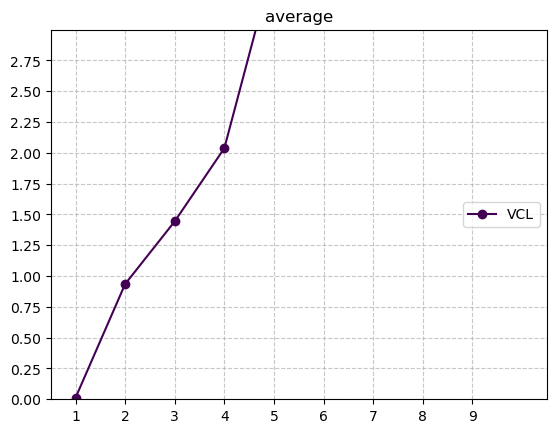

In [20]:

# Create a figure with subplots in a row
from matplotlib import cm, pyplot as plt
import numpy as np
viridis = cm.get_cmap('viridis', len(average_df["method"]))


x = np.arange(1, 11, 1)
for i, (method, ll) in enumerate(zip(average_df["method"], average_df["average_uncert"])):
    plt.plot(
        x,
        ll,
        marker='s' if "Only" in method else 'o',
        linestyle='--' if "Only" in method else '-',
        color=viridis(i),
        label=method,
    )
    plt.ylim((0, 3))
    plt.yticks(np.arange(0, 3, 0.25))
    plt.xlim(0.5, 10.5)
    plt.xticks(np.arange(1, 10, 1))
    plt.title(f'average')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='center right')



In [21]:
with torch.inference_mode():
    uncerts_per_task = []
    acc_per_task = []
    for task_idx in range(10):

        uncerts = []
        accs = []
        for (_, task_vae) in enumerate(task_vaes[task_idx:]):

            task_vae = task_vae.to(device)
            x = task_vae.sample(samples_per_task, task_idx, device)
            y = torch.zeros((samples_per_task, 10), device=device)
            y[:, task_idx] = 1
            y = y.long()
            q = F.softmax(c(x.to(device)), dim=-1)
            q = Categorical(q)
            p = Categorical(y)

            accs.append( 
                (( torch.argmax(c(x.to(device)), dim=-1) == task_idx ).sum() / samples_per_task ).detach().cpu().numpy()

            )
            uncerts.append( kl_divergence(p, q).mean().cpu().numpy())

        uncerts_per_task.append(uncerts)
        acc_per_task.append(accs)
        print("---")

---
---
---
---
---
---
---
---
---
---


In [22]:
uncerts_per_task

[[array(0.01952624, dtype=float32),
  array(9.215442, dtype=float32),
  array(10.65037, dtype=float32),
  array(10.67236, dtype=float32),
  array(12.238344, dtype=float32),
  array(11.307853, dtype=float32),
  array(10.698944, dtype=float32),
  array(7.1981716, dtype=float32),
  array(8.702735, dtype=float32),
  array(11.792307, dtype=float32)],
 [array(0.09845449, dtype=float32),
  array(2.7637122, dtype=float32),
  array(2.524271, dtype=float32),
  array(9.29971, dtype=float32),
  array(3.7990298, dtype=float32),
  array(10.133122, dtype=float32),
  array(5.9290867, dtype=float32),
  array(4.6851177, dtype=float32),
  array(8.935457, dtype=float32)],
 [array(0.06344443, dtype=float32),
  array(7.289819, dtype=float32),
  array(6.1291475, dtype=float32),
  array(6.530866, dtype=float32),
  array(5.4429097, dtype=float32),
  array(5.055995, dtype=float32),
  array(3.1882539, dtype=float32),
  array(4.716743, dtype=float32)],
 [array(0.15208709, dtype=float32),
  array(8.868884, dtype=f

In [23]:
acc_per_task

[[array(0.9921875, dtype=float32),
  array(0.0078125, dtype=float32),
  array(0.0390625, dtype=float32),
  array(0.0625, dtype=float32),
  array(0., dtype=float32),
  array(0.0234375, dtype=float32),
  array(0.03125, dtype=float32),
  array(0.0859375, dtype=float32),
  array(0.0546875, dtype=float32),
  array(0.0078125, dtype=float32)],
 [array(0.9765625, dtype=float32),
  array(0.4140625, dtype=float32),
  array(0.3046875, dtype=float32),
  array(0.015625, dtype=float32),
  array(0.3125, dtype=float32),
  array(0., dtype=float32),
  array(0.0234375, dtype=float32),
  array(0.0859375, dtype=float32),
  array(0., dtype=float32)],
 [array(0.9765625, dtype=float32),
  array(0.1796875, dtype=float32),
  array(0.2265625, dtype=float32),
  array(0.1953125, dtype=float32),
  array(0.2890625, dtype=float32),
  array(0.1015625, dtype=float32),
  array(0.375, dtype=float32),
  array(0.234375, dtype=float32)],
 [array(0.9453125, dtype=float32),
  array(0.0625, dtype=float32),
  array(0.28125, dty

In [24]:
uncerts_per_task

[[array(0.01952624, dtype=float32),
  array(9.215442, dtype=float32),
  array(10.65037, dtype=float32),
  array(10.67236, dtype=float32),
  array(12.238344, dtype=float32),
  array(11.307853, dtype=float32),
  array(10.698944, dtype=float32),
  array(7.1981716, dtype=float32),
  array(8.702735, dtype=float32),
  array(11.792307, dtype=float32)],
 [array(0.09845449, dtype=float32),
  array(2.7637122, dtype=float32),
  array(2.524271, dtype=float32),
  array(9.29971, dtype=float32),
  array(3.7990298, dtype=float32),
  array(10.133122, dtype=float32),
  array(5.9290867, dtype=float32),
  array(4.6851177, dtype=float32),
  array(8.935457, dtype=float32)],
 [array(0.06344443, dtype=float32),
  array(7.289819, dtype=float32),
  array(6.1291475, dtype=float32),
  array(6.530866, dtype=float32),
  array(5.4429097, dtype=float32),
  array(5.055995, dtype=float32),
  array(3.1882539, dtype=float32),
  array(4.716743, dtype=float32)],
 [array(0.15208709, dtype=float32),
  array(8.868884, dtype=f

In [25]:
uncerts_df = {
    "method": ["VCL"],
    "uncert": [uncerts_per_task],
    "acc": [acc_per_task]
}

/tmp/ipykernel_3234299/2386617574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', len(uncerts_df["method"]))


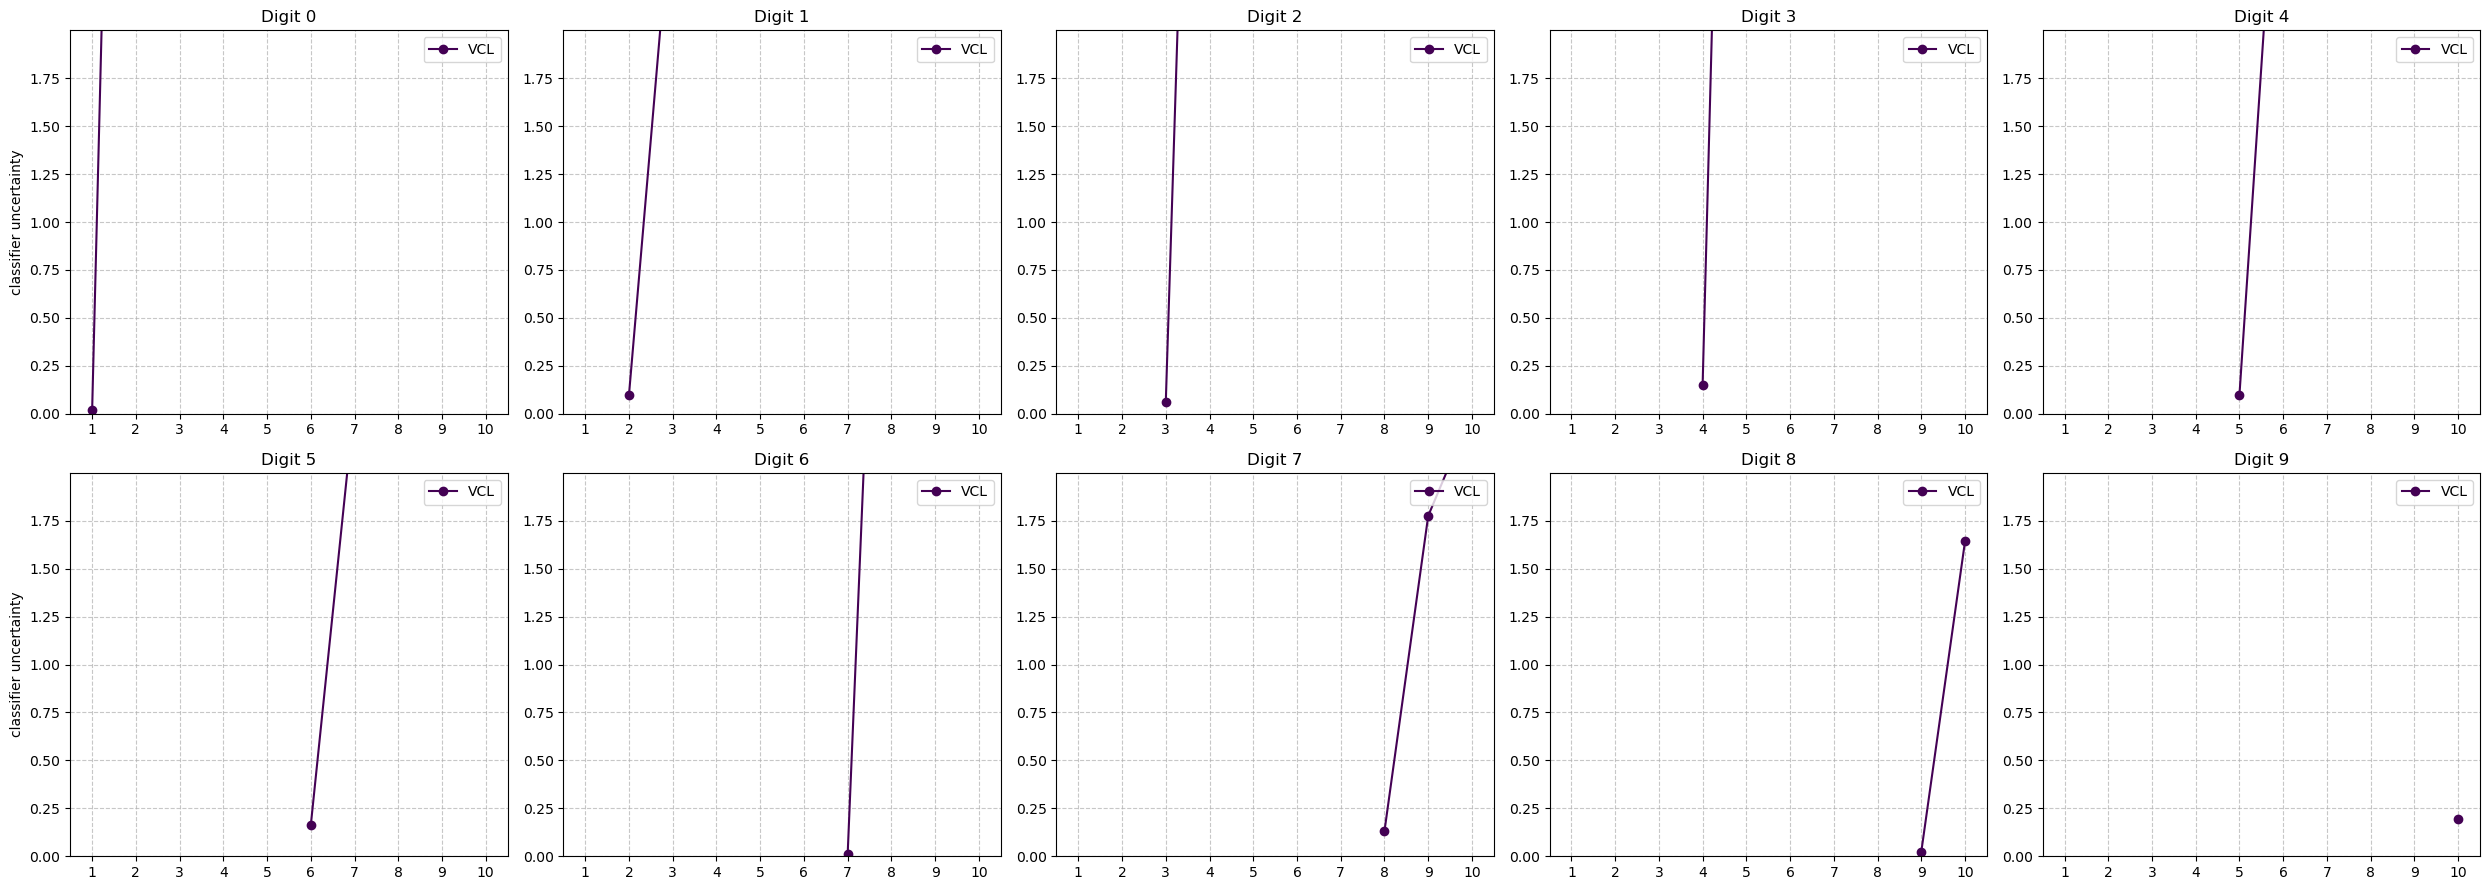

In [26]:
num_tasks = 10

# Create a figure with subplots in a row
from matplotlib import cm, pyplot as plt
import numpy as np



fig, axes = plt.subplots(2, 5, figsize=(25, 9))
axes = axes.flatten()  # Easier indexing

plot_ylims = [
    (-175, -95, 25),
    (-80, -40, 10),
    (-140, -100, 20),
    (-130, -100, 10),
    (-120, -90, 10),
    (-120, -100, 10),
    (-120, -90, 10),
    (-86, -78, 2),
    (-114, -108, 2),
    (-89, -86, 1),
]

viridis = cm.get_cmap('viridis', len(uncerts_df["method"]))


for task in range(num_tasks):
    ax = axes[task]
    
    ax.set_xticks(np.arange(1, 11))
    x = np.arange(task + 1, 11)  # x goes from task+1 to 10
    
    for i, (method, ll) in enumerate(zip(uncerts_df["method"], uncerts_df["uncert"])):
        ax.plot(
            x,
            ll[task],
            marker='s' if "Only" in method else 'o',
            linestyle='--' if "Only" in method else '-',
            color=viridis(i),
            label=method,
        )

    y_min, y_max, y_ticks = 0, 1, 0.25
    y_max += 1
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max, y_ticks))
    ax.set_xlim(0.5, 10.5)

    ax.set_title(f'Digit {task}')
    ax.grid(True, linestyle='--', alpha=0.7)

    if task % 5 == 0:
        ax.set_ylabel('classifier uncertainty')

    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


/tmp/ipykernel_3234299/4176819211.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', len(uncerts_df["method"]))


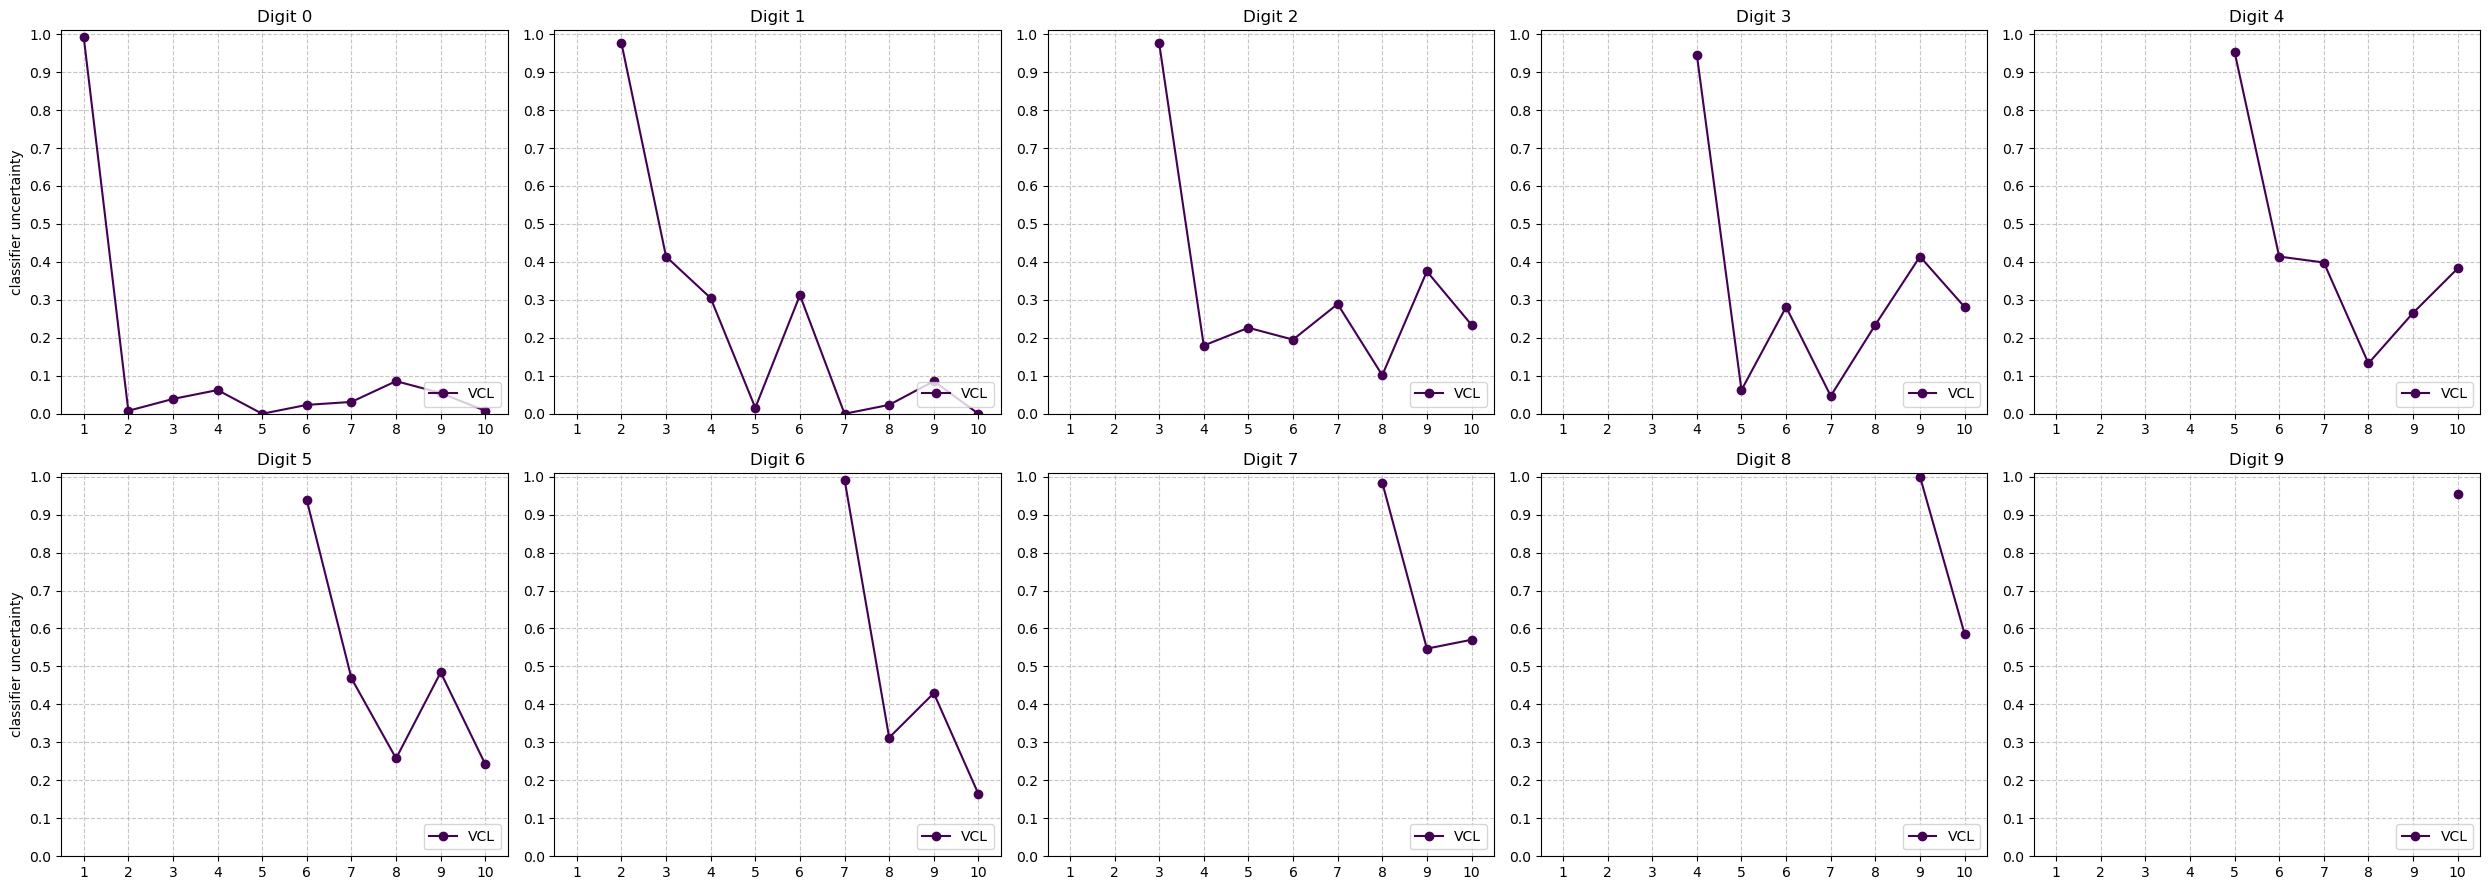

In [27]:
num_tasks = 10

# Create a figure with subplots in a row
from matplotlib import cm, pyplot as plt
import numpy as np



fig, axes = plt.subplots(2, 5, figsize=(25, 9))
axes = axes.flatten()  # Easier indexing



viridis = cm.get_cmap('viridis', len(uncerts_df["method"]))


for task in range(num_tasks):
    ax = axes[task]
    
    ax.set_xticks(np.arange(1, 11))
    x = np.arange(task + 1, 11)  # x goes from task+1 to 10
    
    for i, (method, ll) in enumerate(zip(uncerts_df["method"], uncerts_df["acc"])):
        ax.plot(
            x,
            ll[task],
            marker='s' if "Only" in method else 'o',
            linestyle='--' if "Only" in method else '-',
            color=viridis(i),
            label=method,
        )

    y_min, y_max, y_ticks = 0, 1.01, 0.1
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max, y_ticks))
    ax.set_xlim(0.5, 10.5)

    ax.set_title(f'Digit {task}')
    ax.grid(True, linestyle='--', alpha=0.7)

    if task % 5 == 0:
        ax.set_ylabel('classifier uncertainty')

    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()
